The aim of this analysis is to predit a superconductors critical temperature based on the variables from the superconductors chemical formula. We will be training a few different predictive models and compare them to find the best one.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import sklearn.model_selection as ms
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
conductivity = pd.read_csv("data/train.csv", header=0, na_values='?').dropna()
conductivity.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [3]:
print('\nDataFrame datatypes :\n', conductivity.dtypes)


DataFrame datatypes :
 number_of_elements         int64
mean_atomic_mass         float64
wtd_mean_atomic_mass     float64
gmean_atomic_mass        float64
wtd_gmean_atomic_mass    float64
                          ...   
range_Valence              int64
wtd_range_Valence        float64
std_Valence              float64
wtd_std_Valence          float64
critical_temp            float64
Length: 82, dtype: object


Splitting our dataset into predictor and response vectors.

In [4]:
X = conductivity.drop(['critical_temp'], axis=1) # X variable is the dataset without the class column
X = X.values 
Y = conductivity.iloc[:,81:82].values # Y variable is only the critical temp column
# the 81:82 is important, because otherwise it returns just a 1-dimensional object

Now, because we are using LASSO and Ridge regression, we need to standardize our predictors.

In [5]:
# Standardizing the predictors
X_mean = np.reshape(X.mean(0), (-1,81))
X_std = np.reshape(X.std(0), (-1,81))
X_stand = (X - X_mean) / X_std

Finally, we split our data into training and validation sets.

In [8]:
import sklearn.model_selection as cv 
XTrain, XTest, YTrain, Ytest =\
    cv.train_test_split(X_stand, Y, \
    test_size=0.2, random_state=1)

Now we must tune our hyperparameters for the LASSO and Ridge regression. To do this, we utilize a grid search. The intervals I have chosen were found through trial and error.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
lambda_ridge_range = np.linspace(0.001,0.2,50) 
lambda_ridge_grid = [{'alpha': lambda_ridge_range}]
lambda_lasso_range = np.linspace(0.0001,0.002, 20)
lambda_lasso_grid = [{'alpha': lambda_lasso_range}]

We now utilize k-fold cross validation, where k=11. k=10 is usual, but it can also help to have your choice of k evenly divide your sample size.

In [10]:
model1 = Ridge(max_iter=10000)
cv_ridge = GridSearchCV(estimator=model1,\
param_grid=lambda_ridge_grid,\
cv=ms.KFold(n_splits=11))
cv_ridge.fit(XTrain, YTrain) # alpha = 0.04973469

GridSearchCV(cv=KFold(n_splits=11, random_state=None, shuffle=False),
             estimator=Ridge(max_iter=10000),
             param_grid=[{'alpha': array([0.001     , 0.00506122, 0.00912245, 0.01318367, 0.0172449 ,
       0.02130612, 0.02536735, 0.02942857, 0.0334898 , 0.03755102,
       0.04161224, 0.04567347, 0.04973469, 0.05379592, 0.05785714,
       0.06191837, 0.06597959, 0.07004082, 0.07410204, 0.07816327,
       0.08222449, 0.08628571, 0.09034694, 0.09440816, 0.09846939,
       0.10253061, 0.10659184, 0.11065306, 0.11471429, 0.11877551,
       0.12283673, 0.12689796, 0.13095918, 0.13502041, 0.13908163,
       0.14314286, 0.14720408, 0.15126531, 0.15532653, 0.15938776,
       0.16344898, 0.1675102 , 0.17157143, 0.17563265, 0.17969388,
       0.1837551 , 0.18781633, 0.19187755, 0.19593878, 0.2       ])}])

In [ ]:
model2 = Lasso(max_iter=100000) # I had to put max iter up so high because
                              # otherwise the Lasso was not converging.
cv_lasso = GridSearchCV(estimator=model2,\
param_grid=lambda_lasso_grid,\
cv=ms.KFold(n_splits=11))
cv_lasso.fit(XTrain, YTrain) # alpha = 0.0001

In [16]:
bestLambda_lasso = 0.0001
bestLambda_ridge = 0.04973469

Now we train our regressions using the optimized hyperparameters

In [17]:
cond_Lasso = Lasso(alpha=bestLambda_lasso,max_iter=100000)
cond_Lasso.fit(XTrain, YTrain)
print(cond_Lasso.coef_)

cond_Ridge = Ridge(alpha=bestLambda_ridge,max_iter=10000)
cond_Ridge.fit(XTrain, YTrain)
print(cond_Ridge.coef_)

[-5.42614935e+00  2.57676996e+01 -3.18817524e+01 -1.58224736e+01
  2.44125467e+01 -1.35644627e+01  1.37391829e+00  1.15706924e+01
  1.18374158e+00 -1.11080166e+01  1.61983456e+00  1.62098435e+01
 -3.33588572e+01 -1.39471559e+01  3.01325279e+01 -4.75837114e+01
  1.44791745e+01  2.22297681e+01  4.82692248e+00 -2.33424806e+01
 -1.46066432e+00 -1.29737382e+01  1.00318661e+02  6.28765435e+00
 -1.09695328e+02  3.18971796e+01  1.88185334e+01  1.31630092e+01
 -3.45528179e+00 -7.37285636e+00 -9.93333705e+00 -1.43394893e+01
  1.94801679e-01  5.50318796e+00  8.41269498e+00  5.42871974e+00
 -6.68416526e+00 -5.79242221e+00 -4.01920545e-01  9.44998084e+00
 -2.24237546e+00 -2.37453217e+00  1.62997574e+01  4.76481059e+00
 -1.77200013e+01  1.26112704e+00 -6.07922045e+00 -2.20162530e+01
 -4.11866575e+00  2.70824560e+01 -1.09352977e+01  2.02310463e+01
 -2.77986129e+01 -1.62928267e+01  2.14765810e+01 -6.96861414e+00
  9.37790419e+00 -8.60077318e+00  6.91269476e+00 -4.30187748e+00
  5.71085603e+00 -2.22577

We can look at the differences between the coefficients of each variable from each model to see how different each model is.

In [18]:
print(cond_Lasso.coef_ - cond_Ridge.coef_)

[[ 2.64654470e-02 -7.44491710e-02  5.96755402e-02  7.57724525e-02
  -6.49535480e-02  2.01881609e-02 -4.45670842e-02 -1.91513809e-02
  -1.25041946e-02  5.09390448e-02 -2.51547996e-02 -4.15176958e-02
  -5.36019477e-01  2.96101609e-02  4.58862385e-01 -5.51474925e-01
   6.38654460e-02 -3.01842917e-02  8.57353293e-03  1.90926962e-02
   4.57364396e-02 -4.05949174e-01  1.19539218e+00  4.18136405e-01
  -1.44740523e+00  3.25680539e-01  8.88173285e-02 -6.25671847e-02
  -9.40210731e-03  2.87066196e-01 -3.47186951e-01  5.67395900e-02
  -1.14603455e-01 -4.60074762e-02  1.11284772e-01 -4.15463434e-02
   1.71338688e-02  1.82857947e-02  1.92145529e-02 -5.16295522e-02
   3.17092262e-02  5.13932875e-02 -9.39444913e-02 -4.61803806e-02
   8.28953326e-02  6.38625922e-03 -7.88302271e-03  1.72192828e-02
   7.78536902e-03 -3.23846364e-02  2.39629715e-02 -6.06730439e-02
   9.62432707e-02  3.70557708e-02 -6.73346101e-02  1.11675154e-02
  -1.28097451e-02 -6.45502792e-03 -8.92014979e-03  5.26239841e-02
  -4.53304

The coefficients are very similar. Most are the same out to 2 decimal places.

Do some quick reshaping to get 2d vectors

In [19]:
lasso_train_prediction = np.reshape(cond_Lasso.predict(XTrain), (-1,17010))
lasso_test_prediction = np.reshape(cond_Lasso.predict(XTest), (-1, 4253))
ridge_train_prediction = np.reshape(cond_Ridge.predict(XTrain), (-1, 17010))
ridge_test_prediction = np.reshape(cond_Ridge.predict(XTest), (-1, 4253))

Lasso_MSEtrain = metrics.mean_squared_error(YTrain, lasso_train_prediction.T)
Lasso_MSEtest = metrics.mean_squared_error(Ytest, lasso_test_prediction.T)
Ridge_MSEtrain = metrics.mean_squared_error(YTrain, ridge_train_prediction.T)
Ridge_MSEtest = metrics.mean_squared_error(Ytest, ridge_test_prediction.T)

We have the first two models trained, now we move on to the Principal Component and Partial Least Squares Regressions

In [20]:
from sklearn import decomposition
from sklearn.decomposition import TruncatedSVD

In [ ]:
condPCA = decomposition.PCA()
cond_Decomp = condPCA.fit(XTrain)
X_decomp = cond_Decomp.transform(XTrain)
var_ratio = condPCA.explained_variance_ratio_
np.cumsum(np.round(var_ratio, decimals=4)*100)

We can see above that 12 principal components gets us to ~90% of variance explained, so we use 12 principal components.

Text(0, 0.5, 'explained variance')

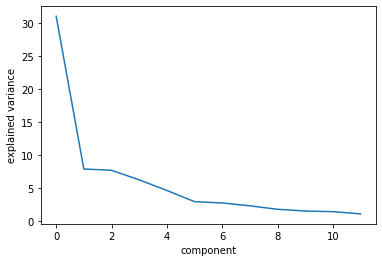

In [21]:
n_components = 12
pca = TruncatedSVD(n_components=n_components)
X_train_pca = pca.fit_transform(XTrain)
X_test_pca = pca.fit_transform(XTest)

components = pca.components_
plt.plot(pca.explained_variance_)
plt.xlabel('component')
plt.ylabel('explained variance')

Our principal components analysis is done, so we now do regression on the principal components.

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
pcr = LinearRegression()
pcr.fit(X_train_pca, YTrain)
pcr_MSEtrain = metrics.mean_squared_error(YTrain,pcr.predict(X_train_pca))
pcr_MSEtest = metrics.mean_squared_error(Ytest, pcr.predict(X_test_pca))

And now we train the partial least squares regression.

In [24]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import scale

In [25]:
pls = PLSRegression(n_components=n_components)
pls.fit(scale(XTrain), YTrain)
pls_MSEtrain = metrics.mean_squared_error(YTrain,pls.predict(scale(XTrain)))
pls_MSEtest = metrics.mean_squared_error(Ytest,pls.predict(scale(XTest)))

To finish off the models, we do an ordinary least squares regression

In [26]:
OLS = LinearRegression()
OLS.fit(XTrain, YTrain)
OLS_MSEtrain = metrics.mean_squared_error(YTrain, OLS.predict(XTrain))
OLS_MSEtest = metrics.mean_squared_error(Ytest, OLS.predict(XTest))

Do some simple print commands to compare training and testing errors.

In [27]:
print('The OLS training error is', OLS_MSEtrain, ' and the OLS testing error is', OLS_MSEtest)
print('The Ridge training error is', Ridge_MSEtrain, ' and the Ridge testing error is', Ridge_MSEtest)
print('The Lasso training error is', Lasso_MSEtrain, ' and the Lasso testing error is', Lasso_MSEtest)
print('The PCR training error is', pcr_MSEtrain, ' and the PCR testing error is', pcr_MSEtest)
print('The PLS training error is', pls_MSEtrain, ' and the PLS testing error is', pls_MSEtest)

The OLS training error is 306.0759047713742  and the OLS testing error is 318.2777505906926
The Ridge training error is 306.0797094248285  and the Ridge testing error is 318.18710645738366
The Lasso training error is 306.07862958529387  and the Lasso testing error is 318.21233505812893
The PCR training error is 484.3618201577728  and the PCR testing error is 864.3148801839544
The PLS training error is 346.96005275106666  and the PLS testing error is 348.75312980339515


The testing and training errors for three of these are very close. It is obvious that PCR and PLS are not the best models for the data. It comes down to OLS, Ridge and Lasso regressions. I think it is safe to say that any three of these would work almost equally as well as the others, but Lasso has the smallest testing error and it stands to be improved the most by finding a more accurate alpha value, so I believe the Lasso regression is the best model.